In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Load and pre-process data

In [2]:
train_df = pd.read_pickle("fhm_blip_features_train.pkl")
test_df = pd.read_pickle("fhm_blip_features_test.pkl")
# train_df = pd.read_pickle("fhm_blip_features_train_roberta.pkl")
# test_df = pd.read_pickle("fhm_blip_features_test_roberta.pkl")

In [3]:
train_df = train_df[["gold_hate", "text_features", "vit-l-14-img_features", "blip_features"]]
test_df = test_df[["gold_hate", "text_features", "vit-l-14-img_features", "blip_features"]]

In [4]:
label_encoder = LabelEncoder()

train_df["gold_hate"] = train_df["gold_hate"].apply(lambda x: x[0])
test_df["gold_hate"] = test_df["gold_hate"].apply(lambda x: x[0])

train_df["gold_hate"] = label_encoder.fit_transform(train_df["gold_hate"])
test_df["gold_hate"] = label_encoder.fit_transform(test_df["gold_hate"])

Extracting the numpy arrays from the dataframe 

In [5]:
img_features = np.vstack(train_df["vit-l-14-img_features"].values)
text_features = np.vstack(train_df["text_features"].values)
blip_features = np.vstack(train_df["blip_features"].values)
targets = train_df["gold_hate"].values
# Concatenate text & blip features
text_features = np.concatenate((text_features, blip_features), axis=1)

# 25% of training data used as validation
img_features_train, img_features_val, text_features_train, text_features_val, targets_train, targets_val = train_test_split(
    img_features, text_features, targets, test_size=0.25
)

img_features_test = np.vstack(test_df["vit-l-14-img_features"].values)
text_features_test = np.vstack(test_df["text_features"].values)
blip_features_test = np.vstack(test_df["blip_features"].values)
text_features_test = np.concatenate((text_features_test, blip_features_test), axis=1)
targets_test = test_df["gold_hate"].values

In [6]:
print("==Train data==")
print(f"img_features shape: {img_features_train.shape}")
print(f"text_features shape: {text_features_train.shape}")
print(f"targets shape: {targets_train.shape}")

print("\n==Validation data==")
print(f"img_features shape: {img_features_val.shape}")
print(f"text_features shape: {text_features_val.shape}")
print(f"targets shape: {targets_val.shape}")

print("\n==Test data==")
print(f"img_features shape: {img_features_test.shape}")
print(f"text_features shape: {text_features_test.shape}")
print(f"targets shape: {targets_test.shape}")

==Train data==
img_features shape: (6375, 768)
text_features shape: (6375, 1536)
targets shape: (6375,)

==Validation data==
img_features shape: (2125, 768)
text_features shape: (2125, 1536)
targets shape: (2125,)

==Test data==
img_features shape: (500, 768)
text_features shape: (500, 1536)
targets shape: (500,)


## Creating the Keras Model

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [8]:
img_input = Input(shape=(768,), name='img_input')
img_dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(img_input)

text_input = Input(shape=(1536,), name='text_input')
text_dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(text_input)

combined_model = Concatenate()([img_dense, text_dense])

x = Dense(128, activation='relu')(combined_model)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[img_input, text_input], outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 1536)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    196,864 │ img_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    786,944 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     98,432 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,090,561 (4.16 MB)

 Trainable params: 1,090,561 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    [img_features_train, text_features_train], 
    targets_train, 
    epochs=30, 
    batch_size=32, 
    validation_data=([img_features_val, text_features_val], targets_val)
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6907 - loss: 1.3004 - val_accuracy: 0.7388 - val_loss: 0.7383
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7640 - loss: 0.6517 - val_accuracy: 0.7238 - val_loss: 0.6505
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8136 - loss: 0.5153 - val_accuracy: 0.7487 - val_loss: 0.6027
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8271 - loss: 0.4762 - val_accuracy: 0.7529 - val_loss: 0.6045
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8451 - loss: 0.4429 - val_accuracy: 0.7435 - val_loss: 0.6292
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8845 - loss: 0.3713 - val_accuracy: 0.7148 - val_loss: 0.6816
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9157 - loss: 0.3294 - val_accuracy: 0.7591 - val_loss: 0.8225
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9340 - loss: 0.2789 - val_accuracy: 0.

In [10]:
from sklearn.metrics import classification_report

predictions = model.predict([img_features_test, text_features_test])
predicted_classes = (predictions > 0.5).astype(int).flatten()

print(classification_report(targets_test, predicted_classes, target_names=label_encoder.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

     hateful       0.73      0.53      0.61       246
 not_hateful       0.64      0.81      0.72       254

    accuracy                           0.67       500
   macro avg       0.69      0.67      0.66       500
weighted avg       0.68      0.67      0.67       500



In [11]:
test_loss, test_accuracy = model.evaluate([img_features_test, text_features_test], targets_test)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7594 - loss: 1.6003 
Test loss: 2.298971176147461
Test accuracy: 0.671999990940094


In [12]:
model.save("bert_model_with_captions.keras")

In [13]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict([img_features_test, text_features_test]).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(targets_test, y_pred_keras)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


In [14]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

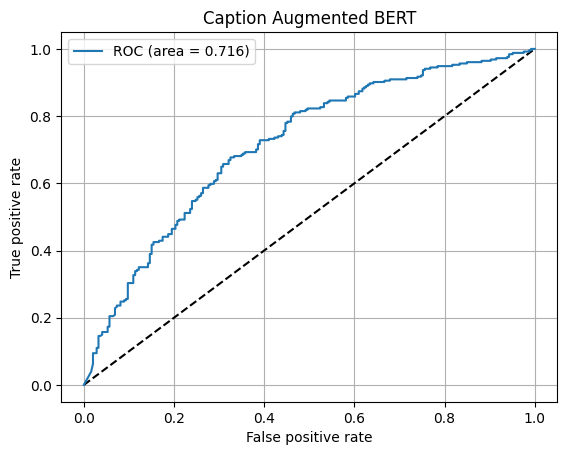

In [15]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Caption Augmented BERT')
plt.legend(loc='best')
plt.grid()
plt.show()

In [17]:
y_preds = y_pred_keras.round()
df = pd.DataFrame(y_preds, columns=["bert_captioned_prediction"])
df.to_csv("bert_captioned_predictions.csv", index_label="img")